# This note book shows:

- How to use script mode for training.
- How to do hyper-parameter tuning
- How to use sagemaker debugger and profiler

Dataset: https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip


Reference: https://docs.aws.amazon.com/sagemaker/latest/dg/prebuilt-containers-extend.html

In [2]:
!pip install smdebug
import sagemaker
import boto3
import os

distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None


## Dataset
Download the data and unzip:

In [ ]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

Save the data into a S3 bucket so that we can access it for training

In [ ]:
import os
session = sagemaker.Session()
bucket = session.default_bucket()
region = session.boto_region_name
role = sagemaker.get_execution_role()

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/train/

## Hyperparameter Tuning

We create two training scripts. One for hyper-parameter tuning and one for the training with optimal hyper-parameters. One reason for having two scripts is that when we do the final training we want to send debugging and profiling hook to the model to monitor several key metrics during the training, but this is not needed when doing hyper-parameter tuning.

For hyper-parameter tuning, we choose the parameters we want to search for, learning_rate and batch_size and create HyperparameterTuner object. 

The tuner object searches for the metric during the search, we need to define this metric (metric_definition) by text that we output during the execution of the training loop. In this case, we defined it to be Test Accuracy and when we do the training/test loops in the model, we shoudl print or log it with "Text Accuracy" as we have defined below. Refer to hpo.py to find the code that outputs "Test Accuracy"

In [7]:
from sagemaker.tuner import (
                            IntegerParameter,
                            CategoricalParameter,
                            ContinuousParameter,
                            HyperparameterTuner,
                            )



hyperparameter_ranges = {
                        "lr": ContinuousParameter(0.001, 0.1),
                        "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
                        }

objective_metric_name = "Test Accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "Test Accuracy", "Regex": "Test Accuracy: ([0-9\\.]+)"}]                 

In [8]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
                    entry_point = "hpo.py",
                    base_job_name = "dog-bread-model-pytorch",
                    role = role,
                    instance_count = 1,
                    instance_type = "ml.m5.large",
                    #hyperparameters = NO hyper parameters!
                    framework_version = "1.8",
                    py_version = "py36",
                    )

tuner = HyperparameterTuner (
                             estimator,
                             objective_metric_name,
                             hyperparameter_ranges,
                             metric_definitions,
                             max_jobs = 4,
                             max_parallel_jobs = 2,
                             objective_type = objective_type,
                             )

In [9]:
data = "s3://" + bucket + "/dogImages/train"
print(data)

s3://sagemaker-us-east-1-286375333242/dogImages/train


Root of the directory is sent in SM_CHANNEL_TRAIN. This can be found in hpo.py as args.SM_CHANNEL_TRAIN. If the key in the fit method below for the path is KEY the channel name would be SM_CHANNEL_KEY. There could also be multiple keys and we will use that when we training the model after finding the best hyper parameters.

In [13]:
tuner.fit({'train' : data}) # including data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


The tuning can take some time. After it is finished we can output the hyper-parameters of the best estimator...

In [14]:
best_estimator = tuner.best_estimator()
best_estimator.hyperparameters()


2022-09-11 09:54:15 Starting - Found matching resource for reuse
2022-09-11 09:54:15 Downloading - Downloading input data
2022-09-11 09:54:15 Training - Training image download completed. Training in progress.
2022-09-11 09:54:15 Uploading - Uploading generated training model
2022-09-11 09:54:15 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"Test Accuracy"',
 'batch_size': '"128"',
 'lr': '0.0017187699829208252',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-bread-model-pytorch-2022-09-11-08-37-53-796"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-286375333242/dog-bread-model-pytorch-2022-09-11-08-37-53-796/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging

Now that we have the optimized hyper-parameters we can full training, with more epochs. To monitor the performance we create debugger and profiler rules and send them to the estimator when it is created.

The debugger can log performance metrics such as loss during the training time, it can also based on the defined rules, check for vanishing or exploding gradients, overfitting, poor weight initialiazation and etc.

The profiler on the other hands check the performance of the instance that is running the training job. For example it checks for CPU or GPU utilization, utilized memory, or available disk space.

In [27]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
         ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
         ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
         Rule.sagemaker(rule_configs.loss_not_decreasing()),
         Rule.sagemaker(rule_configs.vanishing_gradient()),
         Rule.sagemaker(rule_configs.overfit()),
         Rule.sagemaker(rule_configs.overtraining()),
         Rule.sagemaker(rule_configs.poor_weight_initialization()),
         ]

from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig



profiler_config = ProfilerConfig(
                                 system_monitor_interval_millis = 500, 
                                 framework_profile_params = FrameworkProfile(num_steps=10)
                                 )

collection_configs = [
                     CollectionConfig(
                        name="custom_losses",
                        parameters={
                            "include_regex": "CrossEntropyLoss_output_0",
                            "train.save_interval": "50",
                            "eval.save_interval": "10"
                        }
                    )
                    ]

hook_config = DebuggerHookConfig (
                                 collection_configs = collection_configs
                                 )

After setting up the rules, create the estimator by passing the rules and debugger configuration, and also our optimal hyper-parameters. We also set it to run for more epochs. 

In [28]:
hyperparameters = {
                  "epochs" : "5",
                  "batch_size" : "128",
                  "lr": "0.0017"
                  }

estimator = PyTorch (
                    entry_point = "train_my_model.py",
                    base_job_name = "dog-bread-model-pytorch",
                    role = role,
                    instance_count = 1,
                    instance_type = "ml.p3.2xlarge",
                    hyperparameters = hyperparameters,
                    framework_version = "1.8",
                    py_version = "py36",
                    profiler_config = profiler_config,
                    rules = rules,
                    debugger_hook_config = hook_config
                    )

This time we separate the training and test data into two different channels to make the script code easier to understand. It is a minor difference.

In [31]:
estimator.fit(
              {'training' : data + '/train',
               'test'  : data + '/test'}
             )

2022-09-16 10:09:24 Starting - Starting the training job...
2022-09-16 10:09:51 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-09-16 10:11:21 Downloading - Downloading input data.........
2022-09-16 10:12:52 Training - Downloading the training image....................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-09-16 10:16:08,787 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-09-16 10:16:08,817 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-09-16 10:16:08,824 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-09-16 10:16:09,460 sagemaker-training-toolkit INFO     Invoking user sc

In [32]:
pt_model_data = estimator.model_data
print("Model artifact saved at:\n", pt_model_data)

Model artifact saved at:
 s3://sagemaker-us-east-1-286375333242/dog-bread-model-pytorch-2022-09-16-10-09-24-494/output/model.tar.gz


## Visualizing the debugger output

This is based on following some of AWS sagemaker examples:

Find the name and region of the finished training:

In [33]:
training_job_name = estimator.latest_training_job.name
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

Training jobname: dog-bread-model-pytorch-2022-09-16-10-09-24-494
Region: us-east-1


Everything that the debugger hook has recorded:

In [35]:
trial.tensor_names()

[2022-09-16 10:27:11.306 pytorch-1-6-cpu-py36--ml-t3-medium-370ee60fbc7a856e8f67ac271515:35 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-09-16 10:27:12.333 pytorch-1-6-cpu-py36--ml-t3-medium-370ee60fbc7a856e8f67ac271515:35 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'CrossEntropyLoss_output_1',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

We can check the values for example for the registered loss as below:

In [38]:
from smdebug import modes
trial.tensor('CrossEntropyLoss_output_0').values(mode=modes.TRAIN)

{0: array(4.960293, dtype=float32),
 50: array(2.0499477, dtype=float32),
 100: array(1.3227049, dtype=float32),
 150: array(1.2449567, dtype=float32),
 200: array(1.0338361, dtype=float32),
 250: array(0.98604757, dtype=float32)}

Creating functions to plot the tensor output type of the data and then plotting the loss for the training and test vs. the set steps:

In [39]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


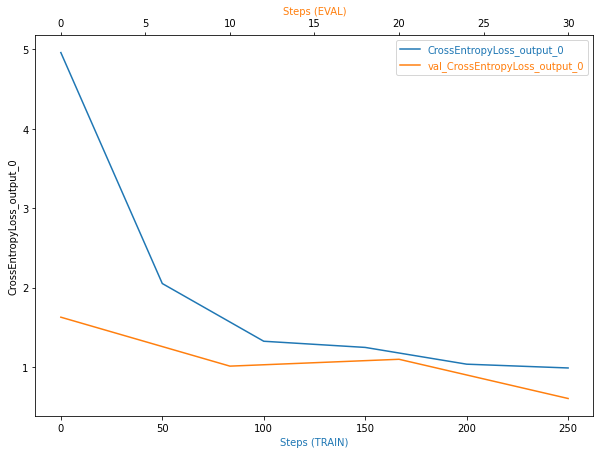

In [40]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

## Visualizing the debugger output

The profiler output can be created by the following codes from AWS examples:

The output would be an HTML file and is shown in the git folder as an example

In [41]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [42]:
! aws s3 ls {rule_output_path} --recursive

2022-09-16 10:26:20     438276 dog-bread-model-pytorch-2022-09-16-10-09-24-494/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-09-16 10:26:19     297552 dog-bread-model-pytorch-2022-09-16-10-09-24-494/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-09-16 10:26:15        552 dog-bread-model-pytorch-2022-09-16-10-09-24-494/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-09-16 10:26:15      42875 dog-bread-model-pytorch-2022-09-16-10-09-24-494/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-09-16 10:26:15       1930 dog-bread-model-pytorch-2022-09-16-10-09-24-494/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-09-16 10:26:15        130 dog-bread-model-pytorch-2022-09-16-10-09-24-494/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-09-16 10:26:15       8408 dog-bread-model-pytorch-2022-09-16-10-09-24-494/rule-

In [43]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-286375333242/dog-bread-model-pytorch-2022-09-16-10-09-24-494/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-286375333242/dog-bread-model-pytorch-2022-09-16-10-09-24-494/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-286375333242/dog-bread-model-pytorch-2022-09-16-10-09-24-494/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-286375333242/dog-bread-model-pytorch-2022-09-16-10-09-24-494/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-u

In [44]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

Executing this shows the HTML of the profiler in the notebook. It may be better to view it externally.

In [ ]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

Due to the transformation, need to create a transform.py file that applied the same transformation done during the training to the image and also loaded the model.

PyTorchModel object is used and the transform.py is set as the entry point to the model.

In [65]:
from sagemaker.pytorch import PyTorchModel

pytorch_model = PyTorchModel(
                             model_data = estimator.model_data, 
                             role = role, 
                             entry_point = 'transform.py', 
                             py_version = 'py36',
                             framework_version = '1.8'
                            )


predictor = pytorch_model.deploy(
                                initial_instance_count = 1, 
                                instance_type = 'ml.m5.xlarge'
                                )

INFO:sagemaker:Creating model with name: pytorch-inference-2022-09-16-11-10-06-857
INFO:sagemaker:Creating endpoint with name pytorch-inference-2022-09-16-11-10-07-407


------!

In [78]:
endpoint_name = predictor.endpoint_name

print("The endpoint name is:")
print(endpoint_name)

The endpoint name is:
pytorch-inference-2022-09-16-11-10-07-407


# Testing the deployed model endpoint

The dog photo used to do the prediction is:


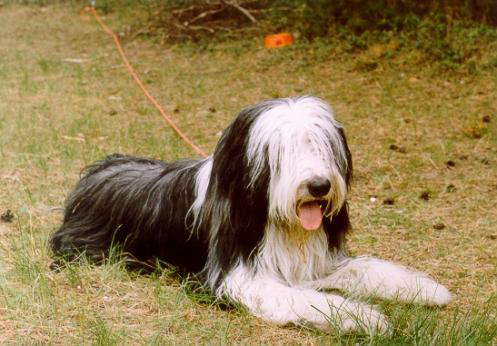

The label of the image is 17
The prediction given by the machine learning model is 17

The dog photo used to do the prediction is:


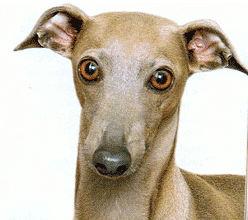

The label of the image is 90
The prediction given by the machine learning model is 90

The dog photo used to do the prediction is:


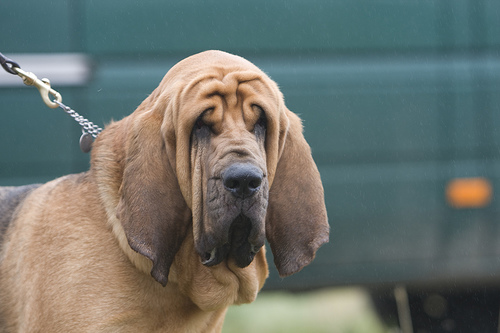

The label of the image is 27
The prediction given by the machine learning model is 27



In [108]:
from sagemaker.serializers import IdentitySerializer

predictor.serializer = IdentitySerializer("image/jpeg")
jpeg_serializer = IdentitySerializer("image/jpeg")


from PIL import Image

files = [
    './dogImages/valid/017.Bearded_collie/Bearded_collie_01222.jpg', 
    './dogImages/valid/090.Italian_greyhound/Italian_greyhound_06122.jpg',
    './dogImages/valid/027.Bloodhound/Bloodhound_01932.jpg',
    ]
    
for file in files:
    # Getting labels
    target_str = 'valid/'
    in_pos = file.index(target_str) + len(target_str)
    label = int(file[in_pos:in_pos+3])
    
    # Displaying image to be predicted
    img = Image.open(file)
    print('The dog photo used to do the prediction is:')
    display(img)
    
    # Querying endpoint
    image = open(file, 'rb').read()
    response = predictor.predict(image, initial_args={'ContentType':'image/jpeg'})
    prediction = np.argmax(response[0]) + 1    
    
    print(f'The label of the image is {label}')
    print(f'The prediction given by the machine learning model is {prediction}\n')

# # 

## Loading a docker Image

In [91]:
import boto3

client=boto3.client('sts')
account=client.get_caller_identity()['Account']

my_session=boto3.session.Session()
region=my_session.region_name

algorithm_name="pytochcontainertest9"
ecr_image='{}.dkr.ecr.{}.amazonaws.com/{}:latest'.format(account, region, algorithm_name)

ecr_image

'286375333242.dkr.ecr.us-east-1.amazonaws.com/pytochcontainertest9:latest'

In [92]:
import sagemaker

from sagemaker import get_execution_role
from sagemaker.estimator import Estimator

estimator=Estimator(
    image_uri=ecr_image,
    role=get_execution_role(),
    base_job_name='pytochcontainertest9',
    instance_count=1,
    instance_type='ml.p2.xlarge'
)



In [ ]:
estimator.fit()

In [ ]:
# Deleting the endpoint(s)  when done
predictor.delete_endpoint()